In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers
from tensorflow.compat.v1.keras.layers import Lambda, Input, Dense ,Input, Flatten, Multiply, Reshape, concatenate
from tensorflow.compat.v1.keras.losses import mse, binary_crossentropy
from tensorflow.compat.v1.keras.utils import plot_model
from  tensorflow.compat.v1.keras.initializers import glorot_uniform  # Or your initializer of choice
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Activation, Dropout,Conv1D, MaxPooling1D, Conv2DTranspose, BatchNormalization


In [3]:
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import seaborn as sn
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import os
import umap
import pandas as pd
from scipy import stats

In [4]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [5]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

from factor_analyzer import FactorAnalyzer, Rotator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [7]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
# Define computing resource
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.Session(config=config)

In [9]:
def sampling(m_v):

    z_mean, z_log_var = m_v #(mean and var)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]

    epsilon = K.random_normal(shape=(batch, dim))
    sample = z_mean + K.exp(0.5 * z_log_var) * epsilon
    return sample

In [10]:
def masking(mask_data):
    inputs, outputs_unmasked =mask_data
    mask = tf.math.logical_not(tf.math.equal(inputs, 0))
    mask = tf.cast(mask, dtype=outputs_unmasked.dtype) #convert it to the same data type as the outputs_unmasked
    outputs_masked= outputs_unmasked*mask
    return outputs_masked
    

In [11]:
def filterTheDict(dictObj, callback):
    newDict = dict()
    for (key, value) in dictObj.items():
        if callback((key, value)):
            newDict[key] = value
    return newDict



In [12]:
def vae_loss(true, pred):
    #Need help here. Need to mask off mes=0, but the complier doesn't accept logical operation
    #mask = tf.math.logical_not(tf.math.equal(true, 0)) # Find all 0 in y_true and mark them as False
    #mask = tf.cast(mask, dtype=true.dtype) # Convert the previous statistics from zero to a matrix of 1, 0
    #pred_mask = pred*mask
   # diff2 = (K.flatten(true) - K.flatten(pred)) ** 2.0
    #reconstruction_loss = 0.0
        #num = 0
    #for i in range(50):
     #   if true[i] == 0:
     #       reconstruction_loss += diff2[i]
            #num += 1
            
    reconstruction_loss = mse(K.flatten(true), K.flatten(pred)) *50

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = 0.5 * reconstruction_loss + beta * 0.5 * kl_loss
    return vae_loss

In [13]:
os.getcwd()

'/Users/jianqiuzhang/Documents/Psychology/duckworth-grit-scale-data'

In [14]:
# load data
data_read = pd.read_table('/Users/jianqiuzhang/Documents/Psychology/BIG5/data.csv')
#data_read = pd.read_table('/Users/jianqiuzhang/Documents/Psychology/duckworth-grit-scale-data/data.csv')

col_name = list(data_read.columns)
data = data_read.iloc[:,col_name.index('E1'):col_name.index('O10')+1]


exp_data = data.values
zeroindex=(exp_data==0)
scaler = StandardScaler()
scaled_exp_data_df=data.copy()
scaled_exp_data_df=pd.DataFrame(scaler.fit_transform(scaled_exp_data_df), columns=data.columns)
scaled_exp_data=scaled_exp_data_df.values
scaled_exp_data[zeroindex]=0

scaled_X_train, scaled_X_test  =  train_test_split(scaled_exp_data, test_size=0.2, random_state=42)

#df_scaled_X_train=pd.DataFrame(scaled_X_train,columns=data.columns)
#df_scaled_X_train.to_csv('train_data.csv', index=False, header=True)
#df_scaled_X_test=pd.DataFrame(scaled_X_test,columns=data.columns)
#df_scaled_X_test.to_csv('test_data.csv', index=False, header=True)

In [15]:
scaled_exp_data.shape

(19719, 50)

In [16]:
col_names = col_name[col_name.index('E1'):col_name.index('O10')+1]
print(col_names)

['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'O10']


In [17]:
code_book_raw = pd.read_table('/Users/jianqiuzhang/Documents/Psychology/duckworth-grit-scale-data/codebookItemsBig5.txt',delimiter=',\t')

code_book_raw.columns=list(['Code','Content'])
codes=list(code_book_raw['Code'])
content=list(code_book_raw['Content'])
code_book=pd.DataFrame(data=content,index=codes)
code_book.columns=list(['Content'])
#code_book.index=codes
#code_book.drop(['Code'], axis=1)
print(code_book)
code_book.loc['A1']

                                               Content
E1                         I am the life of the party.
E2                                 I don't talk a lot.
E3                   I feel comfortable around people.
E4                           I keep in the background.
E5                              I start conversations.
E6                               I have little to say.
E7     I talk to a lot of different people at parties.
E8           I don't like to draw attention to myself.
E9         I don't mind being the center of attention.
E10                       I am quiet around strangers.
N1                          I get stressed out easily.
N2                      I am relaxed most of the time.
N3                               I worry about things.
N4                                 I seldom feel blue.
N5                              I am easily disturbed.
N6                                 I get upset easily.
N7                             I change my mood a lot.
N8        

/Users/jianqiuzhang/opt/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Content    I feel little concern for others.
Name: A1, dtype: object

In [23]:
## hyper params
latent_dim =8
hidden_nodes=100


In [24]:
## VAE model
# build encoder
inputs = Input(shape=(50,), name='encoder_input')

block1 = Dense(hidden_nodes, kernel_initializer='he_normal', activation='relu')(inputs)
block1 = BatchNormalization(axis=-1)(block1)
#block2 = Dense(hidden_nodes, kernel_initializer='he_normal', activation='relu')(block1)
#block2 = BatchNormalization(axis=-1)(block2)
flatten = Flatten()(block1)
z_mean = Dense(latent_dim, name='z_mean')(flatten)
z_log_var = Dense(latent_dim, name='z_log_var')(flatten)

In [25]:
# use reparameterization trick
x = [z_mean, z_log_var]
z = Lambda(sampling, name='z_sample')(x)

# instantiate encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [26]:
# build decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
de_block1 = Dense(hidden_nodes, activation='relu')(latent_inputs)
de_block1 = BatchNormalization()(de_block1)
#de_block2 = Dense(hidden_nodes, activation='relu')(de_block1)
#de_block2 = BatchNormalization()(de_block2)
outputs_unmasked = Dense(50, activation='linear')(de_block1)



In [27]:

embedding = layers.Embedding(input_dim=50, output_dim=50, mask_zero=True)
masked_output = embedding(inputs)
#print(masked_output._keras_mask)
masking_layer = layers.Masking()
outputs = masking_layer(outputs_unmasked)


In [28]:
# instantiate decoder
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [29]:
# show summary
plot_model(vae, to_file='beta-vae.png', show_shapes=True)
encoder.summary()
decoder.summary()
vae.summary()

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          5100        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 100)          400         dense_3[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           batch_normalization_2[0][0]      
______

In [30]:
## hyper params
batch_size = 64
epochs =200
lr = 0.0003
decay = 1e-6
beta = 1
## data spliting


In [31]:
# Compiling
adam = Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=decay, amsgrad=True)
vae.compile(optimizer= adam, loss = vae_loss, metrics=['acc'])

In [32]:
initial_weights = vae.get_weights()

backend_name = K.backend()
if backend_name == 'tensorflow': 
    k_eval = lambda placeholder: placeholder.eval(session=K.get_session())
elif backend_name == 'theano': 
    k_eval = lambda placeholder: placeholder.eval()
else: 
    raise ValueError("Unsupported backend")

new_weights = [k_eval(glorot_uniform()(w.shape)) for w in initial_weights]

vae.set_weights(new_weights)
hist = vae.fit(scaled_X_train, scaled_X_train, epochs=epochs, batch_size=batch_size, validation_split=0.15, verbose=2)


Train on 13408 samples, validate on 2367 samples
Epoch 1/200
13408/13408 - 5s - loss: 25.1226 - acc: 0.0263 - val_loss: nan - val_acc: 0.0494
Epoch 2/200
13408/13408 - 2s - loss: 22.6853 - acc: 0.0372 - val_loss: 21.5497 - val_acc: 0.0473
Epoch 3/200
13408/13408 - 3s - loss: 20.3757 - acc: 0.0583 - val_loss: 19.4698 - val_acc: 0.0832
Epoch 4/200
13408/13408 - 2s - loss: 18.7491 - acc: 0.0906 - val_loss: 18.3349 - val_acc: 0.0934
Epoch 5/200
13408/13408 - 3s - loss: 18.1048 - acc: 0.1056 - val_loss: 18.0205 - val_acc: 0.1056
Epoch 6/200
13408/13408 - 2s - loss: 17.9392 - acc: 0.1089 - val_loss: 17.9002 - val_acc: 0.1086
Epoch 7/200
13408/13408 - 3s - loss: 17.8127 - acc: 0.1123 - val_loss: 17.7869 - val_acc: 0.1107
Epoch 8/200
13408/13408 - 2s - loss: 17.7427 - acc: 0.1144 - val_loss: 17.7449 - val_acc: 0.1213
Epoch 9/200
13408/13408 - 2s - loss: 17.6529 - acc: 0.1201 - val_loss: 17.6505 - val_acc: 0.1082
Epoch 10/200
13408/13408 - 2s - loss: 17.5821 - acc: 0.1225 - val_loss: 17.5976 - 

Epoch 85/200
13408/13408 - 3s - loss: 16.9490 - acc: 0.1874 - val_loss: 17.0222 - val_acc: 0.1981
Epoch 86/200
13408/13408 - 2s - loss: 16.9513 - acc: 0.1920 - val_loss: 17.0156 - val_acc: 0.1888
Epoch 87/200
13408/13408 - 2s - loss: 16.9384 - acc: 0.1893 - val_loss: 17.0647 - val_acc: 0.1994
Epoch 88/200
13408/13408 - 2s - loss: 16.9676 - acc: 0.1852 - val_loss: 17.0038 - val_acc: 0.1850
Epoch 89/200
13408/13408 - 2s - loss: 16.9389 - acc: 0.1884 - val_loss: 16.9442 - val_acc: 0.1842
Epoch 90/200
13408/13408 - 2s - loss: 16.9527 - acc: 0.1917 - val_loss: 16.9906 - val_acc: 0.1952
Epoch 91/200
13408/13408 - 2s - loss: 16.9302 - acc: 0.1891 - val_loss: 16.9722 - val_acc: 0.1791
Epoch 92/200
13408/13408 - 2s - loss: 16.9518 - acc: 0.1879 - val_loss: 17.0092 - val_acc: 0.1943
Epoch 93/200
13408/13408 - 2s - loss: 16.9598 - acc: 0.1850 - val_loss: 17.0154 - val_acc: 0.1990
Epoch 94/200
13408/13408 - 2s - loss: 16.9537 - acc: 0.1926 - val_loss: 17.0188 - val_acc: 0.1969
Epoch 95/200
13408/1

Epoch 168/200
13408/13408 - 3s - loss: 16.8593 - acc: 0.1964 - val_loss: 16.9140 - val_acc: 0.2036
Epoch 169/200
13408/13408 - 2s - loss: 16.8527 - acc: 0.1993 - val_loss: 16.9463 - val_acc: 0.2045
Epoch 170/200
13408/13408 - 3s - loss: 16.8764 - acc: 0.2044 - val_loss: 16.9032 - val_acc: 0.1986
Epoch 171/200
13408/13408 - 3s - loss: 16.8842 - acc: 0.1976 - val_loss: 16.9470 - val_acc: 0.1969
Epoch 172/200
13408/13408 - 3s - loss: 16.8796 - acc: 0.2022 - val_loss: 16.9333 - val_acc: 0.2032
Epoch 173/200
13408/13408 - 3s - loss: 16.8736 - acc: 0.1997 - val_loss: 16.9742 - val_acc: 0.2159
Epoch 174/200
13408/13408 - 2s - loss: 16.8641 - acc: 0.2012 - val_loss: 16.9288 - val_acc: 0.2138
Epoch 175/200
13408/13408 - 2s - loss: 16.8579 - acc: 0.1959 - val_loss: 16.9378 - val_acc: 0.1994
Epoch 176/200
13408/13408 - 2s - loss: 16.8804 - acc: 0.1994 - val_loss: 16.9873 - val_acc: 0.1977
Epoch 177/200
13408/13408 - 2s - loss: 16.8623 - acc: 0.1993 - val_loss: 16.9227 - val_acc: 0.1965
Epoch 178/

          0         1         2         3         4         5         6  \
0  1.000000 -0.011966 -0.008299  0.007549 -0.004382 -0.005264  0.000411   
1 -0.011966  1.000000  0.011001 -0.055827  0.003676  0.041062 -0.067803   
2 -0.008299  0.011001  1.000000 -0.022988 -0.022106  0.030910  0.015549   
3  0.007549 -0.055827 -0.022988  1.000000  0.002672 -0.050785 -0.026780   
4 -0.004382  0.003676 -0.022106  0.002672  1.000000 -0.005349 -0.006313   
5 -0.005264  0.041062  0.030910 -0.050785 -0.005349  1.000000 -0.031309   
6  0.000411 -0.067803  0.015549 -0.026780 -0.006313 -0.031309  1.000000   
7 -0.037756  0.003500  0.006249 -0.000669 -0.001744  0.007563  0.001046   

          7  
0 -0.037756  
1  0.003500  
2  0.006249  
3 -0.000669  
4 -0.001744  
5  0.007563  
6  0.001046  
7  1.000000  


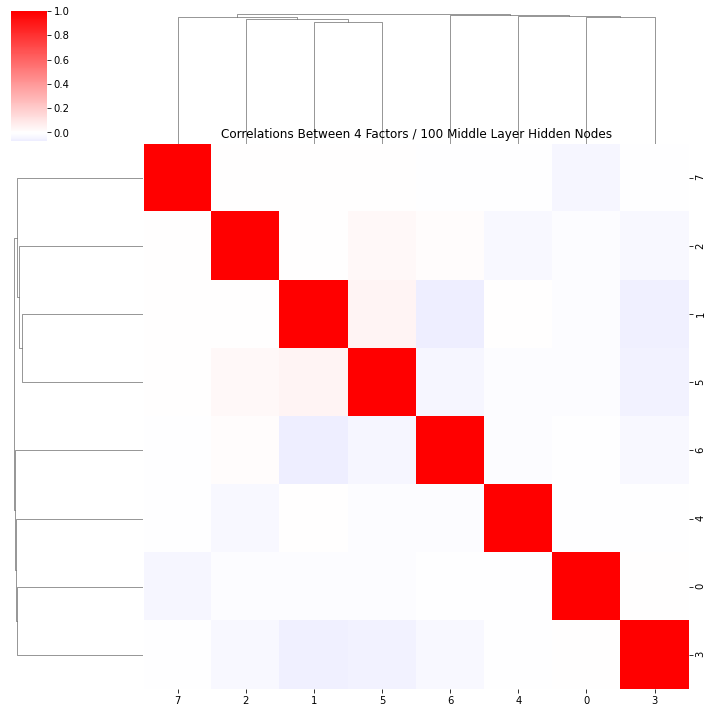

In [33]:
#scaled_X_train, scaled_X_test  =  train_test_split(scaled_exp_data, test_size=0.2, random_state=42)

#hist = vae.fit(scaled_X_train, scaled_X_train, epochs=epochs, batch_size=batch_size, validation_split=0.15, verbose=2)
# correlation for latent components
# correlation for latent components
latent_pred = encoder.predict(scaled_exp_data)[0]
#print(latent_pred)
#pearson_coef, p_value = stats.pearsonr(latent_pred[:,0], latent_pred[:,2])
#print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
corr_df = pd.DataFrame(data=latent_pred)
corr = corr_df.corr()
cluster_plot=sn.clustermap(corr, cmap='bwr', center=0)
#cluster_plot.fig.suptitle('')
node=str(hidden_nodes)
cluster_plot.ax_heatmap.set_title('Correlations Between 4 Factors / '+ node+' Middle Layer Hidden Nodes')
#cluster_plot.title('Basic 3 Factors Correlation Dendrogram)            
#cluster_plot.savefig("Big5ClusterReluGreat1.png")
print(corr)



MSE is: 0.5323713300401978


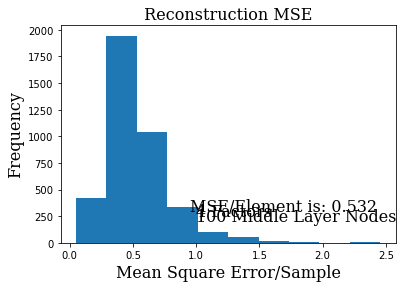

In [34]:

# reconstruction performance
latent_pred = encoder.predict(scaled_X_test)[2]
recon= decoder.predict(latent_pred)
#recon = vae.predict(scaled_X_test)
recon_loss_1 = ((scaled_X_test - recon) ** 2).mean(axis=1)
plt.hist(recon_loss_1)
plt.title(' Reconstruction MSE ', fontdict=font)
recon_loss = ((scaled_X_test - recon) ** 2).mean(axis=None)
format_float = "{:.3f}".format(recon_loss)
print_text='MSE/Element is: '+str(format_float)
xpos=1
ytop=300
ystep=50
plt.text(xpos-0.05, ytop, print_text, fontdict=font)
plt.text(xpos, ytop-ystep, '4 Factors', fontdict=font)
plt.text(xpos, ytop-ystep*2, node + ' Middle Layer Nodes', fontdict=font)
plt.xlabel('Mean Square Error/Sample', fontdict=font)
plt.ylabel('Frequency', fontdict=font)
print('MSE is:', recon_loss)

plt.show()
#plt.savefig('Big5MSEHist1ReluGreat1.png')

In [ ]:
# UMAP for data
#data_umap = umap.UMAP(n_neighbors=1, min_dist=.1)
#embedding_org = pd.DataFrame(data_umap.fit_transform(exp_data), columns = ['UMAP1','UMAP2'])
#sns_plot = sn.scatterplot(x='UMAP1', y='UMAP2', data=embedding_org)

In [ ]:
loss,_  = vae.evaluate(scaled_X_test, scaled_X_test, batch_size=64, verbose=0)

print('Test loss vae:', loss)


In [35]:
filename='Big8Layers1Encoder100ReluData2Copy1'

In [36]:
decoder.save('Big8Layers1Decoder100ReluData2Copy1.h5')
encoder.save('Big8Layers1Encoder100ReluData2Copy1.h5')


In [ ]:
encoder.summary()
decoder.summary()

In [37]:
#latent_dim=9

latent_pred_sample = encoder.predict(scaled_exp_data)[0]
out=decoder.predict(latent_pred_sample)
indata=pd.DataFrame(data=scaled_exp_data, columns=col_names)
inout=pd.DataFrame(data=out, columns=col_names)
factors=[]
for i in range(latent_dim):
    factors.append('F'+str(i))
factor_names=list(factors)    
for i in range(latent_dim):
    inout.insert(i,factor_names[i],latent_pred_sample[:,i],True)

inout

,F0,F1,F2,F3,F4,F5,F6,F7,E1,E2,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
0,-0.082469,0.589131,2.375994,-1.262981,0.205114,0.954923,-0.124984,-0.174797,0.790732,-0.742669,...,0.604212,-0.803143,0.274017,-0.565627,0.830152,-0.762095,0.952902,-0.064444,-0.018714,0.824279
1,-1.061454,-0.843485,-0.882641,-1.310654,-0.341916,1.111059,0.489443,-0.242196,-0.775540,0.544139,...,-1.124699,0.886449,-1.232084,0.716234,-1.442852,0.952868,-1.155526,-1.080872,-0.681344,-1.724135
2,0.680220,-2.254120,0.097834,-0.998845,0.077882,-2.296095,-1.609272,-0.440230,0.733585,-0.518418,...,0.576203,0.343540,0.716229,0.194074,1.065661,-0.529101,0.949407,0.723671,0.786457,0.817814
3,1.168157,-0.116542,-1.134332,0.801990,-0.395424,-1.205151,-0.150414,0.178872,-0.446495,0.565985,...,0.239352,0.494834,0.657799,0.382471,0.284379,-0.436807,-0.081897,0.479027,0.330904,0.453527
4,-0.059313,-0.959579,0.208385,0.266092,1.817458,0.452452,1.209160,-0.995420,0.177196,-0.303791,...,-1.138694,-0.042199,-0.667861,-0.226097,-0.623527,0.113127,-0.055842,-1.109104,-0.499478,-0.684178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19714,1.181734,-1.177754,-0.601476,-0.348380,-0.158726,-0.802916,1.125942,-1.908783,-0.463926,0.684625,...,-1.475641,0.800447,0.543995,0.305594,0.110314,-0.502019,-0.471952,-1.428055,0.376147,0.098665
19715,-0.028753,0.520340,-0.402108,-0.410096,0.164550,1.721372,0.623934,-0.017296,-0.388875,0.483727,...,-0.819783,0.401247,-1.035776,0.346897,-0.865046,0.632838,-0.489189,-0.800440,-0.903899,-1.087649
19716,0.442020,-0.429743,-1.857319,1.241598,-0.261756,-0.547396,-1.169407,1.017612,-0.444513,0.243414,...,0.240033,0.926858,0.115537,0.813322,-0.228828,0.564409,-0.284471,0.548023,0.335188,-0.205494
19717,0.441868,-0.338844,-0.546066,-1.251467,-0.367758,-1.306439,-0.235251,-0.763430,-0.603586,0.790371,...,0.152676,-0.083401,0.533664,-0.030890,0.447514,-0.538838,0.268762,0.196728,0.316973,0.357837


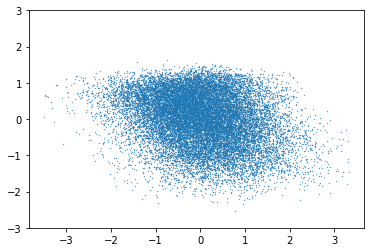

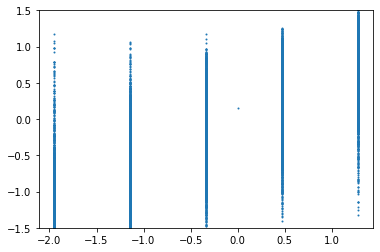

0.7354781750271998
0.7558603193954381
0.7917168889984637
0.7778039250802469
0.8016975633184178
0.7533119306388254
0.7972115502198411
0.680303600072792
0.705727904119918
0.751302671931185
0.7641082437207884
0.7027274262122898
0.7595046913051261
0.6387763448909457
0.6466315714210482
0.7844889978616186
0.7954098050089441
0.8322115295520766
0.7699320144956769
0.7667257464662656
0.7081514119513984
0.7128647523789697
0.6715158309736898
0.8185900768473028
0.7463225491309672
0.7282163995984255
0.7876117125005173
0.6723341883164549
0.7812238392067112
0.6790598254007845
0.6890301642256745
0.7239311536501486
0.6082257214138121
0.7405833850637256
0.720688916513585
0.7446694329104304
0.6812201841847149
0.6375616563689313
0.7065076265415795
0.6517890631960843
0.7725045517154039
0.7928529316219699
0.7977733705832531
0.7456814786741691
0.7457775539338437
0.8632211702180707
0.7358345460370644
0.7820622330407886
0.6142038387019217
0.7789526226274032


In [38]:
col='E3'
fac=1;
plt.scatter(inout.iloc[:,fac],inout[col],s=0.1);
  #plt.xlim(-2, 2)
plt.ylim(-3, 3)
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=10, c='red')
plt.show()
plt.scatter(indata[col], inout[col],s=1);
plt.ylim(-1.5, 1.5)
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=10, c='red')

plt.show()
corr_array=[]
for coln in col_names:
    corr_num=inout[coln].corr(indata[coln]) 
    corr_array.append(corr_num)
    print(corr_num)
#inout.iloc[:,fac].corr(inout[col])

In [39]:
import statistics as stat
meancorr=sum(corr_array)/len(corr_array)
print(meancorr)
stdcorr=stat.stdev(corr_array)
print(stdcorr)

0.7369978617452978
0.05760753918848441


In [40]:
latent_dim=len(latent_pred_sample[0])
ffCorr=inout.corr()

facLoad=ffCorr.iloc[latent_dim:50+latent_dim,0:latent_dim]
idx=list(facLoad.index)
col=list(facLoad.columns)
factor_loadings=facLoad
rotator = Rotator()
facLoadRotate=rotator.fit_transform(facLoad)
factor_loadings=pd.DataFrame(facLoadRotate,index=idx,columns=col)
factor_loadings

,F0,F1,F2,F3,F4,F5,F6,F7
E1,0.119777,0.013594,0.940275,-0.009155,0.174493,0.115059,0.115235,-0.082066
E2,0.004566,-0.045405,-0.947918,-0.019872,0.160564,-0.005375,-0.207710,0.014463
E3,0.077421,-0.023315,0.824597,-0.170285,0.084020,0.351664,0.363204,0.017301
E4,0.088880,-0.023830,-0.943482,0.056223,0.116163,-0.209298,-0.095561,-0.001671
E5,0.047923,0.086650,0.907786,-0.119907,0.023544,0.124152,0.309010,-0.034282
E6,0.100893,-0.256956,-0.839895,0.073005,0.257787,-0.132058,-0.223146,0.132146
E7,0.065354,0.042882,0.927148,-0.057209,0.076007,0.157441,0.241477,-0.007838
E8,0.064392,0.055994,-0.946172,-0.077676,-0.017730,-0.032113,0.075630,0.153341
E9,0.064943,0.068396,0.940401,0.009428,0.160472,0.082682,-0.010240,-0.172486
E10,0.118792,-0.024352,-0.918918,0.050770,0.045131,-0.263631,-0.097268,-0.010767


          0         1         2         3         4         5         6  \
0  1.000000 -0.022814  0.018300  0.006770  0.059167 -0.032286  0.003695   
1 -0.022814  1.000000  0.015678 -0.008390 -0.031411  0.022639 -0.017850   
2  0.018300  0.015678  1.000000  0.008172 -0.003177  0.042541  0.052436   
3  0.006770 -0.008390  0.008172  1.000000 -0.002003 -0.090387 -0.043771   
4  0.059167 -0.031411 -0.003177 -0.002003  1.000000 -0.013447 -0.026081   
5 -0.032286  0.022639  0.042541 -0.090387 -0.013447  1.000000 -0.029529   
6  0.003695 -0.017850  0.052436 -0.043771 -0.026081 -0.029529  1.000000   
7  0.019997 -0.111460 -0.026236 -0.009730 -0.054544  0.006891 -0.017089   

          7  
0  0.019997  
1 -0.111460  
2 -0.026236  
3 -0.009730  
4 -0.054544  
5  0.006891  
6 -0.017089  
7  1.000000  


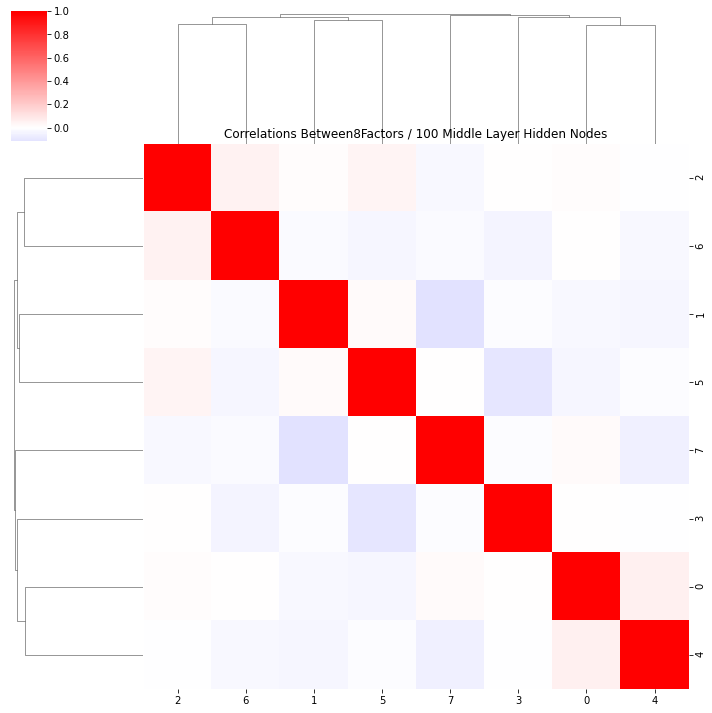

In [42]:

latent_pred = encoder.predict(scaled_exp_data)[0] @ rotator.rotation_ 
corr_df = pd.DataFrame(data=latent_pred)
corr = corr_df.corr()
cluster_plot=sn.clustermap(corr, cmap='bwr', center=0)
node=str(hidden_nodes)
cluster_plot.ax_heatmap.set_title('Correlations Between'+str(latent_dim)+'Factors / '+ node+' Middle Layer Hidden Nodes')
#cluster_plot.title('Basic 3 Factors Correlation Dendrogram)            
#cluster_plot.savefig("Big5ClusterReluGreat1.png")
print(corr)
corr=corr.round(2)
corr.to_csv('Big8corrOfRotatedFactors2.csv', index=True, header=True)

In [43]:
factor_columns=list(factor_loadings.columns)
factor_loadings_abs=factor_loadings.abs()
#max_values = factor_loadings_abs.max(axis=0)
#print(max_values)
#max_values.sort_values(axis = 0, ascending = False, inplace = True, na_position ='last')      
#sorted_factor_colums=max_values.index
#print(sorted_factor_colums)
#sorted_factor_loadings=factor_loadings[sorted_factor_colums]
sorted_factor_loadings=factor_loadings

#sorted_factor_loadings.columns = factor_columns
#sorted_factor_loadings.set_axis(factor_columns, axis=1)
#sorted_factor_loadings.reset_index(factor_columns)
#print(sorted_factor_loadings)

In [ ]:
cvsfilename=filename+'-FactorLoadings.csv'
sorted_factor_loadings.to_csv(cvsfilename, index=True, header=True)

In [44]:
sortAllF=pd.DataFrame(columns=factor_columns)
for i in range(latent_dim):
   current_factor=sorted_factor_loadings.iloc[0:50,i]
   #print(current_factor)
   current_factor_abs=current_factor.abs()
   current_factor_abs.sort_values(axis = 0, ascending = False, inplace = True, na_position ='last')      
   idx=current_factor_abs[current_factor_abs>0.2].index
   sorted_currentFactor=current_factor.loc[idx]
   #print(sorted_currentFactor)

   current_sortAllF=sorted_factor_loadings.loc[idx] 
   #print(current_sortAllF) 
   if(len(sorted_currentFactor)>0):
      first=sorted_currentFactor.iloc[0]
      print(first) 
      if(sorted_currentFactor.iloc[0]<0):
         current_sortAllF *=(-1)
      length_cf=sorted_currentFactor.size
      #print(length_cf)
      if(length_cf>15):
         current_sortAllF_abs=current_sortAllF.abs()
         #print(current_sortAllF_abs)

         max_index = current_sortAllF_abs.idxmax(axis=1)
         #print(max_index)
         keep_idx = max_index[max_index == factor_columns[i]].index
         if(keep_idx.size > 10):    
            current_sortAllF=current_sortAllF.loc[keep_idx]
         else :
            current_sortAllF =current_sortAllF.iloc[0:10]

      current_sortAllF=current_sortAllF.round(2)
      code_content=code_book.loc[current_sortAllF.index]  
      current_sortAllF.insert(0,'content',code_content.iloc[:,0],True)
      print(current_sortAllF)   
      sortAllF=sortAllF.append(current_sortAllF)
      #sortAllF=sortAllF.append(pd.DataFrame(data=factor_columns))
      sortAllF=sortAllF.append(pd.DataFrame(range(1)))
   #print(current_sortAllF)
CurrentFilename=filename+'-FinalFactorLoadingsRotatedUnsorted'+'.csv'
#print(sortAllF.columns)
sortAllF.to_csv(CurrentFilename, index=True, header=True)

0.5277922455115437
                                              content    F0    F1    F2    F3  \
O4             I am not interested in abstract ideas.  0.53 -0.63 -0.05 -0.08   
O2    I have difficulty understanding abstract ideas.  0.47 -0.71 -0.09  0.03   
N4                                I seldom feel blue.  0.41 -0.13  0.26 -0.20   
A3                                   I insult people.  0.34  0.18  0.14  0.36   
C2                      I leave my belongings around.  0.34  0.26  0.05  0.85   
C6  I often forget to put things back in their pro...  0.31  0.10 -0.04  0.89   
C4                           I make a mess of things.  0.22  0.03 -0.12  0.80   
C7                                      I like order.  0.22  0.11 -0.09 -0.90   
N2                     I am relaxed most of the time.  0.20  0.05  0.17  0.06   
N5                             I am easily disturbed.  0.20 -0.27 -0.12  0.24   

      F4    F5    F6    F7  
O4  0.09 -0.17 -0.17  0.39  
O2  0.02 -0.30 -0.04  0.32  
N4

In [ ]:
#from tensorflow import keras
decoder=keras.models.load_model('Big9Layers1Decoder100ReluData2Copy1-1.h5')
encoder=keras.models.load_model('Big9Layers1Encoder100ReluData2Copy1-1.h5')


#new_vae = keras.models.load_model('Big5To3FactorVae')

In [ ]:
# UMAP for latent space
latent_pred = encoder.predict(exp_data)[0]
data_umap = umap.UMAP(n_neighbors=5, min_dist=.1)
embedding = pd.DataFrame(data_umap.fit_transform(latent_pred), columns=['UMAP1', 'UMAP2'])
#sns_plot = sn.scatterplot(x='UMAP1', y='UMAP2', data=embedding)

In [ ]:

# load numpy array from csv file
from numpy import loadtxt
# load array
corr_FA = loadtxt('corrFA.csv', delimiter=',')
# print the array
print(corr_FA)

In [ ]:
fig, axes = plt.subplots(2,3)

# just plot things on each individual axes

plt.subplots_adjust(wspace=0.20, hspace=0.2)
fig.set_size_inches(15,9)

X = np.arange(10)
Y = np.arange(11)/10

axes[0][0].bar(X + 0.00, corr_array[0:10], color = 'b', width = 0.25,label ='Beta-VAE')
axes[0][0].bar(X + 0.3, corr_FA[0:10], color = 'r', width = 0.25,label ='Factor Analysis')
axes[0][0].set_xticks(X)
axes[0][0].set_yticks(Y)
axes[0][0].set_xticklabels(col_names[0:10])
axes[0][0].legend()
axes[0][0].set_title('Extraversion Items',size=12)

axes[0][1].bar(X + 0.00, corr_array[10:20], color = 'b', width = 0.25,label ='Beta-VAE')
axes[0][1].bar(X + 0.3, corr_FA[10:20], color = 'r', width = 0.25,label ='Factor Analysis')
axes[0][1].set_xticks(X)
axes[0][1].set_yticks(Y)
axes[0][1].set_xticklabels(col_names[10:20])
axes[0][1].legend()
axes[0][1].set_title('Neuroticism Items',size=12)

axes[0][2].bar(X + 0.00, corr_array[20:30], color = 'b', width = 0.25,label ='Beta-VAE')
axes[0][2].bar(X + 0.3, corr_FA[20:30], color = 'r', width = 0.25,label ='Factor Analysis')
axes[0][2].set_xticks(X)
axes[0][2].set_yticks(Y)
axes[0][2].set_xticklabels(col_names[20:30])
axes[0][2].legend()
axes[0][2].set_title('Agreeableness Items',size=12)

axes[1][0].bar(X + 0.00, corr_array[30:40], color = 'b', width = 0.25,label ='Beta-VAE')
axes[1][0].bar(X + 0.3, corr_FA[0:10], color = 'r', width = 0.25,label ='Factor Analysis')
axes[1][0].set_xticks(X)
axes[1][0].set_yticks(Y)
axes[1][0].set_xticklabels(col_names[30:40])
axes[1][0].legend()
axes[1][0].set_title('Conscientiousness Items',size=12)

axes[1][1].bar(X + 0.00, corr_array[40:50], color = 'b', width = 0.25,label ='Beta-VAE')
axes[1][1].bar(X + 0.3, corr_FA[40:50], color = 'r', width = 0.25,label ='Factor Analysis')
axes[1][1].set_xticks(X)
axes[1][1].set_yticks(Y)
axes[1][1].set_xticklabels(col_names[40:50])
axes[1][1].legend()
axes[1][1].set_title('Openness Items',size=12)
#plt.title(' Correlation between input and reconstructed input  ', fontdict=font)
#figE.tight_layout()
#plt.savefig('Correlations',dpi=400)
plt.show()


In [ ]:
 # curve NELBO
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))
fig, ax = plt.subplots(figsize=golden_size(6))
hist_vae = {k:hist.history[k] for k in ('loss', 'val_loss')}
hist_vae_df = pd.DataFrame(hist_vae)
hist_vae_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99 * hist_vae_df[1:].values.min(),
            1.1 * hist_vae_df[1:].values.max())

In [ ]:
embedding.iloc[:, 0]

In [ ]:
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(embedding)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 16), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(embedding)


In [ ]:
plt.scatter(embedding.iloc[:,0], embedding.iloc[:,1], c=kmeans.labels_[:], s=5, cmap='Spectral');
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=10, c='red')
plt.show()

In [ ]:
kmeans.labels_[:]

In [ ]:
 plt.hist(latent_pred)